# word2vec and classification

Analysis of the [Amazon Fine Food Reviews dataset on Kaggle](https://www.kaggle.com/snap/amazon-fine-food-reviews).
GitHub repository with this analysis: https://github.com/JungeAlexander/kaggle-amazon-fine-food-reviews

The goal of the analysis is to classify positive (4-5 stars) and negative (1-2 stars) reviews based on the
review content.

Some inspiration can be found here:

- https://www.kaggle.com/c/word2vec-nlp-tutorial
- https://www.kaggle.com/gpayen/d/snap/amazon-fine-food-reviews/building-a-prediction-model/notebook
- https://www.kaggle.com/inspector/d/snap/amazon-fine-food-reviews/word2vec-logistic-regression-0-88-auc/notebook

In [33]:
from gensim.models import Word2Vec, word2vec
import logging
import nltk
import numpy as np
from nltk.corpus import stopwords
import numpy as np
import os
import pandas as pd
import seaborn as sns
#from sklearn import
import sqlite3
import re
from tqdm import tqdm

In [18]:
logging.basicConfig(level=logging.INFO)
%matplotlib inline

In [3]:
# Load the punkt tokenizer used for splitting reviews into sentences
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

# Labelling good and bad reviews

To obtain binary class labels, reviews with 4-5 stars are considered good and assigned a '1' class label while reviews with less than 3 stars are considered bad and assigned a '0' class label. Reviews with 3 stars are ignored.

In [4]:
connection = sqlite3.connect('../input/database.sqlite')
reviews = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3""", connection)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3f2df2fcc0>]], dtype=object)

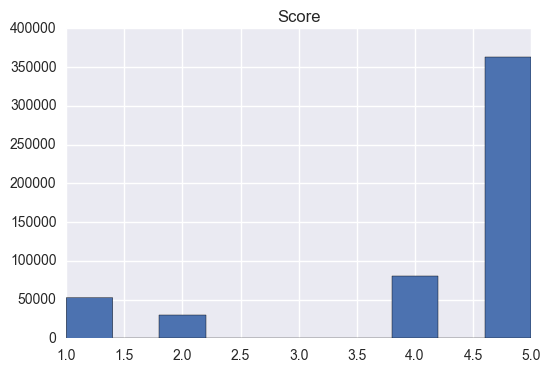

In [5]:
reviews.hist('Score')

We observe that the data set is heavily biased towards reviews with a score of 5.

In [6]:
reviews['Class'] = 1 * (reviews['Score'] > 3)

In [7]:
reviews.head(n=2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Class
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0


## Split into training and test sets

Split the data set into training and test sets. To ensure indendence of training and test set and generalizability of the model, make sure that no product (identified by `ProductId`) and no user (identified by `UserId`) is present in both training and test set.

This is implemented by first sorting the data set by `ProductId`, splitting into equally sized training and test set (no shuffling!) and lastly removing any reviews from the test set where either user or product ID also appears in the training set. Of course, this will make the training and test sets unequally sized but ¯\\\_\_(ツ)\_\_/¯

In [8]:
reviews.sort_values('ProductId', axis=0, inplace=True)

In [9]:
train_size = int(len(reviews) * 0.5)
train_reviews = reviews.iloc[:train_size,:]
test_reviews = reviews.iloc[train_size:,:]

In [10]:
test_remove = np.logical_or(test_reviews['ProductId'].isin(train_reviews['ProductId']),
                          test_reviews['UserId'].isin(train_reviews['UserId']))
test_reviews = test_reviews[np.logical_not(test_remove)]

In [11]:
print('Training set contains {:d} reviews.'.format(len(train_reviews)))
print('Test set contains {:d} reviews ({:d} removed).'.format(len(test_reviews), sum(test_remove)))

Training set contains 262907 reviews.
Test set contains 151198 reviews (111709 removed).


In [12]:
n_pos_train = sum(train_reviews['Class'] == 1)
print('Training set contains {:.2%} positive reviews'.format(n_pos_train/len(train_reviews)))
n_pos_test = sum(test_reviews['Class'] == 1)
print('Test set contains {:.2%} positive reviews'.format(n_pos_test/len(test_reviews)))

Training set contains 84.93% positive reviews
Test set contains 82.37% positive reviews


## Preparing review text

Convert each review in the training set to a list of sentences where each sentence is in turn a list of words.
Besides splitting reviews into sentences, non-letters and (optionally) stop words are removed and all words
coverted to lower case.

Inspired by: https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-2-word-vectors

In [13]:
def review_to_wordlist( review, remove_stopwords=False ):
    """
    Convert a review to a list of words. Removal of stop words is optional.
    """
    # remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review)
    
    # convert to lower case and split at whitespace
    words = review_text.lower().split()
    
    # remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]

    return words

In [14]:
def review_to_sentences( review, tokenizer, remove_stopwords=False ):
    """
    Split review into list of sentences where each sentence is a list of words.
    Removal of stop words is optional.
    """
    # use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(review.strip())

    # each sentence is furthermore split into words
    sentences = []    
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            sentences.append(review_to_wordlist(raw_sentence, remove_stopwords))
            
    return sentences

In [15]:
train_sentences = []  # Initialize an empty list of sentences
for review in tqdm(train_reviews['Text']):
    train_sentences += review_to_sentences(review, tokenizer)

100%|██████████| 262907/262907 [01:14<00:00, 3546.57it/s]


In [16]:
train_sentences[0]

['this',
 'witty',
 'little',
 'book',
 'makes',
 'my',
 'son',
 'laugh',
 'at',
 'loud']

## Training a word2vec model

In [19]:
model_name = 'train_model'
if not os.path.exists(model_name): 
    # Set values for various parameters
    num_features = 300    # Word vector dimensionality                      
    min_word_count = 40   # Minimum word count                        
    num_workers = 3       # Number of threads to run in parallel
    context = 10          # Context window size                                                                                    
    downsampling = 1e-3   # Downsample setting for frequent words

    # Initialize and train the model (this will take some time)
    model = word2vec.Word2Vec(train_sentences, workers=num_workers, \
                size=num_features, min_count = min_word_count, \
                window = context, sample = downsampling)

    # If you don't plan to train the model any further, calling 
    # init_sims will make the model much more memory-efficient.
    model.init_sims(replace=True)

    # It can be helpful to create a meaningful model name and 
    # save the model for later use. You can load it later using Word2Vec.load()
    model.save(model_name)
else:
    model = Word2Vec.load(model_name)

INFO:root:Loading previously computed word2vec model from train_model.
INFO:gensim.utils:loading Word2Vec object from train_model
INFO:gensim.utils:setting ignored attribute syn0norm to None
INFO:gensim.utils:setting ignored attribute cum_table to None


In [31]:
model.doesnt_match("banana apple orange sausage".split())

'sausage'

In [30]:
model.doesnt_match("vanilla chocolate cinnamon dish".split())

'dish'

In [21]:
model.most_similar("great")

[('fantastic', 0.7974022030830383),
 ('terrific', 0.778639554977417),
 ('wonderful', 0.7695246934890747),
 ('fabulous', 0.7191793918609619),
 ('good', 0.7056754231452942),
 ('awesome', 0.6772215366363525),
 ('excellent', 0.6546066999435425),
 ('perfect', 0.635776162147522),
 ('superb', 0.6311653852462769),
 ('phenomenal', 0.6143761277198792)]

In [20]:
 model.most_similar("awful")

INFO:gensim.models.word2vec:precomputing L2-norms of word weight vectors


[('terrible', 0.7411801815032959),
 ('horrible', 0.7315601110458374),
 ('disgusting', 0.6701241731643677),
 ('aweful', 0.6651712656021118),
 ('gross', 0.6525599360466003),
 ('nasty', 0.6149296760559082),
 ('horrid', 0.5932258367538452),
 ('dreadful', 0.5807441473007202),
 ('amazing', 0.5632752776145935),
 ('odd', 0.556433916091919)]

## Build classifier using word embedding

In [32]:
model.syn0.shape

(10821, 300)

## TODO

- classifiers with and without word2 vec